# Speech Emotion Detection Classifier

## 1. Import all the necessary libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Audio processing libraries
import librosa
import librosa.display
import soundfile as sf 

# Visualization libraries
import IPython.display as ipd
from IPython.display import Audio

# Machine learning libraries
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Deep Learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf 


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Data Loading

In [2]:
Ravdess = "ravdess/audio_speech_actors_01-24/"
Crema = "crema/AudioWAV/"
Tess = "tess/TESS Toronto emotional speech set data/"
Savee = "savee/ALL/"

### 2.1 Data Exploration

✅ 1. Exploring Datasets: Extracts .wav files from directories

✅ 2. Mapping Emotions: Converts filenames into emotion labels for each dataset

#### 2.1.1 Function to explore datasets 

In [3]:
def extract_label(filename, dataset):
    if dataset == "RAVDESS":
        emotion_code = int(filename.split("-")[2])
        emotion_dict = {1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}
        return emotion_dict.get(emotion_code, "unknown")
    elif dataset == "CREMA":
        emotion_map = {"NEU": "neutral", "HAP": "happy", "SAD": "sad", "ANG": "angry", "FEA": "fearful", "DIS": "disgust"}
        return emotion_map.get(filename.split("_")[2], "unknown")
    elif dataset == "TESS":
        return filename.split("_")[2][:-4] if filename.split("_")[2][:-4] in ["neutral", "happy", "sad", "angry", "fearful", "disgust", "surprised"] else "unknown"
    elif dataset == "SAVEE":
        emotion_map = {'a': 'angry', 'd': 'disgust', 'f': 'fearful', 'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprised'}
        return emotion_map.get(filename[:2] if filename[:2] in emotion_map else filename[0], "unknown")
    return "unknown"

#### Collect dataset file paths


In [4]:
ravdess_files = [os.path.join(Ravdess, actor, f) for actor in os.listdir(Ravdess) for f in os.listdir(os.path.join(Ravdess, actor))]
crema_files = [os.path.join(Crema, f) for f in os.listdir(Crema)]
tess_files = [os.path.join(Tess, subdir, f) for subdir in os.listdir(Tess) if os.path.isdir(os.path.join(Tess, subdir)) for f in os.listdir(os.path.join(Tess, subdir))]
savee_files = [os.path.join(Savee, f) for f in os.listdir(Savee)]

#### Create DataFrames with extracted labels


In [5]:
ravdess_df = pd.DataFrame({'Path': ravdess_files, 'Emotions': [extract_label(os.path.basename(f), "RAVDESS") for f in ravdess_files]})
crema_df = pd.DataFrame({'Path': crema_files, 'Emotions': [extract_label(os.path.basename(f), "CREMA") for f in crema_files]})
tess_df = pd.DataFrame({'Path': tess_files, 'Emotions': [extract_label(os.path.basename(f), "TESS") for f in tess_files]})
savee_df = pd.DataFrame({'Path': savee_files, 'Emotions': [extract_label(os.path.basename(f), "SAVEE") for f in savee_files]})


##### Combine all datasets into one DataFrame


In [6]:
all_data = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)


##### Save the combined dataset


In [7]:
all_data.to_csv("all_speech_emotions.csv", index=False)
print("\nCombined dataset saved as 'all_speech_emotions.csv'. ")



Combined dataset saved as 'all_speech_emotions.csv'. 


##### Display Emotion Distribution


In [8]:
print("\nOverall Emotion Distribution:")
all_data['Emotions'] = all_data['Emotions'].replace({"calm": "neutral"})
all_data['Emotions'] = all_data['Emotions'].replace({"unknown": "unknown"})



Overall Emotion Distribution:


#### Emotion Mapping

In [9]:
emotion_mapping = {
    "neutral": "neutral",
    "sad": "sad",
    "angry": "angry",
    "disgust": "disgust",
    "happy": "happy",
    "fearful": "fearful",
    "surprised": "surprised",
    "surprise": "surprised"
}

In [10]:
all_data['Emotions'] = all_data['Emotions'].map(emotion_mapping).fillna("unknown")
print(all_data['Emotions'].value_counts())

Emotions
happy        1321
angry        1321
disgust      1321
sad          1319
neutral      1310
unknown      1280
fearful       921
surprised     192
Name: count, dtype: int64


## 4. 📊 Visualization

## 4.1 Basic Visualizations: 
### 1️⃣ Emotion Distribution Plots

The following code explores, maps emotions, and visualizes the distribution of emotions from all four datasets:

We will use Matplotlib and Seaborn to plot: 

✅ Bar Chart - Emotion counts

✅ Pie Chart - Emotion percentage

✅ Histogram - Distribution of emotion occurrences

In [11]:
# Count occurrences of each emotion
emotion_counts = all_data['Emotions'].value_counts()

# 🎨 Set seaborn theme
sns.set_theme(style="darkgrid")

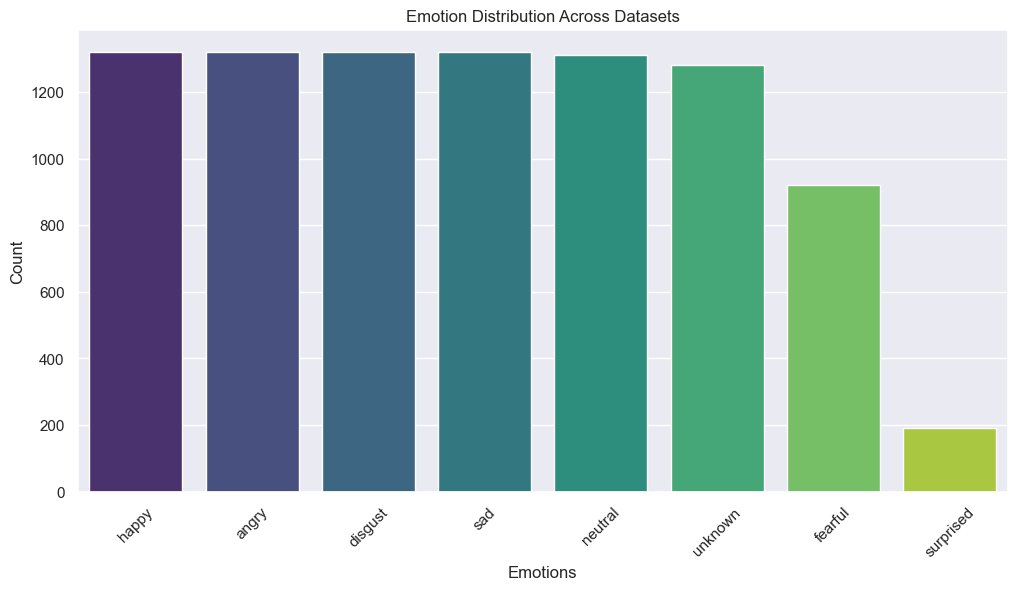

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(x=all_data['Emotions'], order=all_data['Emotions'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution Across Datasets")
plt.show()

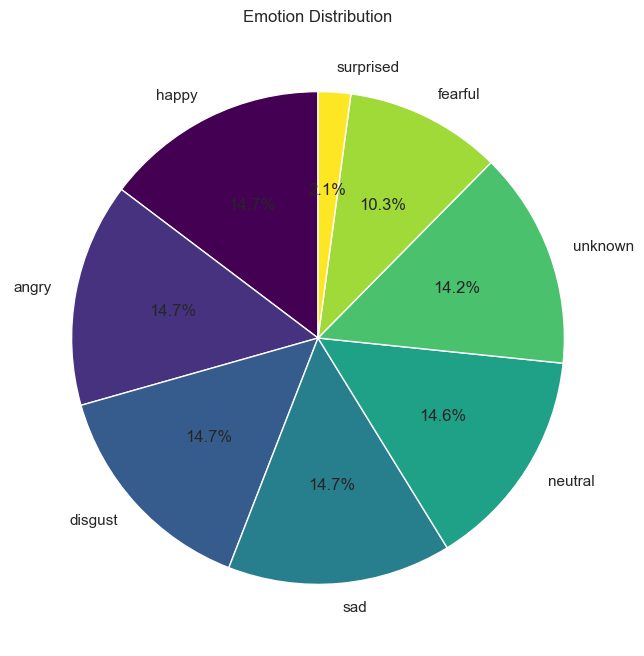

In [13]:
plt.figure(figsize=(8, 8))
all_data['Emotions'].value_counts().plot.pie(autopct='%1.1f%%', cmap='viridis', startangle=90)
plt.title("Emotion Distribution")
plt.ylabel("")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_27208\4098296446.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(all_data['Emotions'], bins=len(emotion_counts), kde=False, palette="viridis")


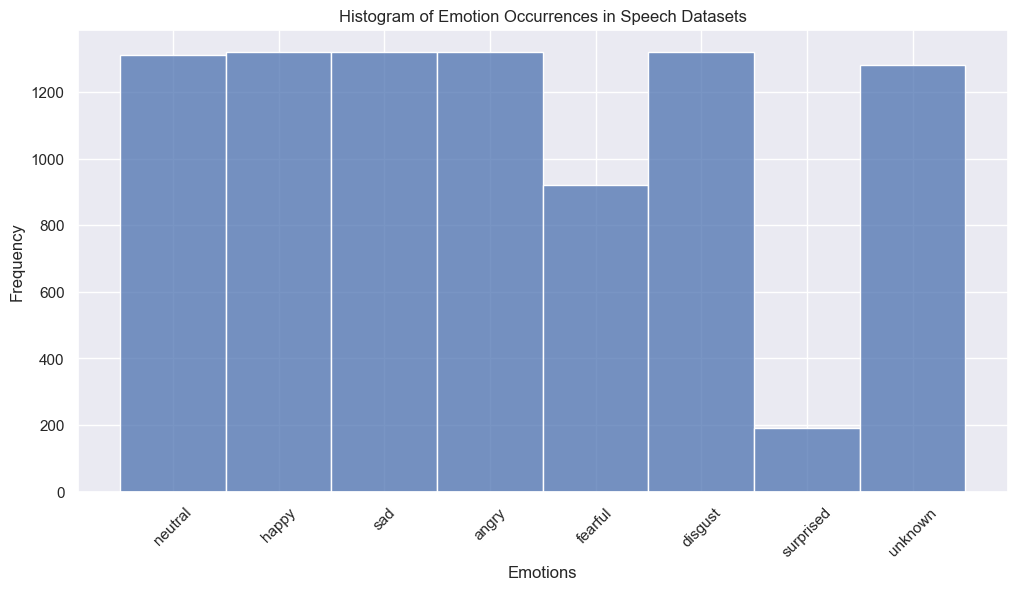

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(all_data['Emotions'], bins=len(emotion_counts), kde=False, palette="viridis")
plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Histogram of Emotion Occurrences in Speech Datasets")
plt.xticks(rotation=45)
plt.show()

### 2️⃣ Audio Signal Visualizations


### Plot waveplots and Spectogram for each emotion

**Waveplots -** Waveplots let us know the loudness of the audio at a given time.

**Spectograms -** A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time.
 
It’s a representation of frequencies changing with respect to time for given audio/music signals.

#### Define functions for waveplot and spectrogram visualization

In [15]:
def create_waveplot(data, sr, emotion):
    """
    Function to create a waveplot for an audio signal.
    
    Parameters:
    - data: The audio time series
    - sr: The sampling rate of the audio file
    - emotion: The emotion label for the given audio
    
    Displays a waveplot representing the amplitude variations of the audio signal over time
    """
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    

#### Define spectogram function

In [16]:
def create_spectrogram(data, sr, emotion):
    """
    Function to create a spectrogram for an audio signal
    
    Parameters:
    -data: The audio time series
    -sr: The sampling rate of the audio file
    -emotion: The emotion label for the given audio
    
    Displays a spectrogram representing the frequency content of the audio signal over time
    """
    
    X= librosa.stft(data) # Short-Time Fourier Transform(STFT)
    xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

### Load and visualize a sample audio file

#### Define the emotion to analyze

##### Load the audio file

##### Retrieve a sample audio file path corresponding to the selected emotion

##### Plot waveplot and spectrogram

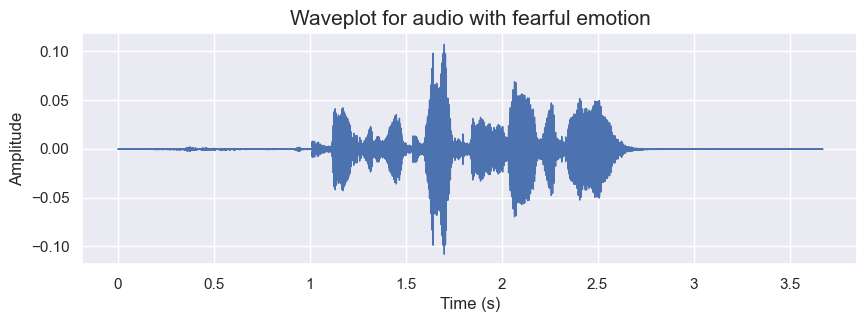

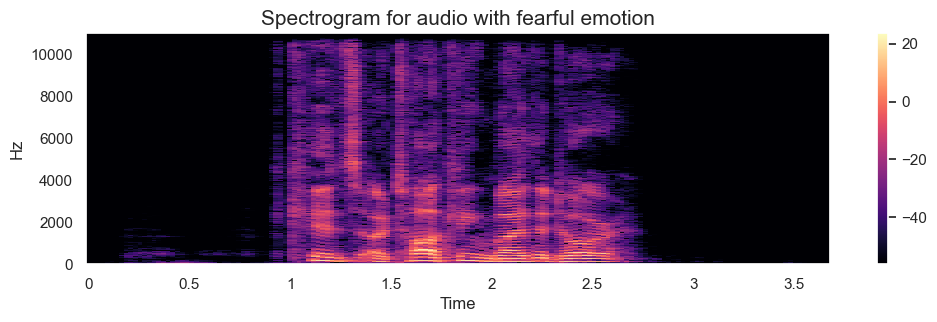

In [ ]:
emotion = 'fearful'
filtered_data = all_data[all_data.Emotions == emotion]
if not filtered_data.empty:
    path = filtered_data.iloc[0]['Path']
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
else:
    print(f"No audio files found for emotion: {emotion}")


##### Play the audio file

In [22]:
Audio(path)

##### Angry emotion

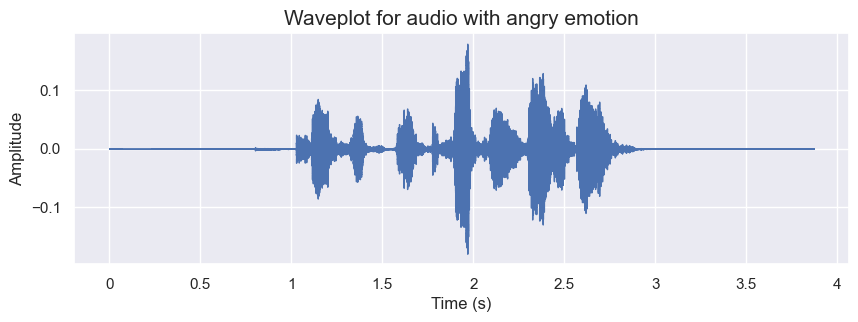

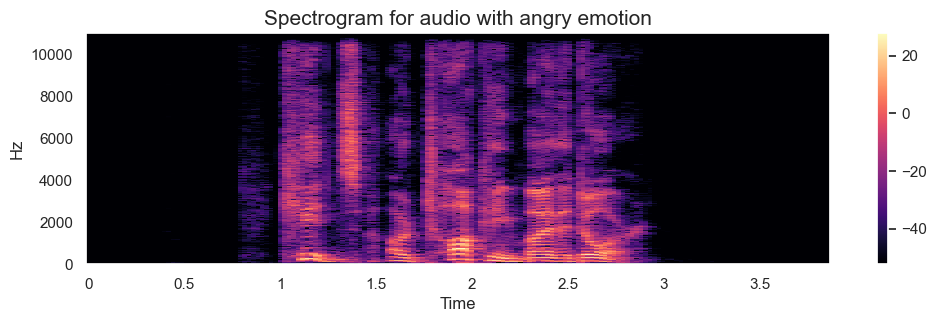

In [ ]:
emotion = 'angry'
filtered_data = all_data[all_data.Emotions == emotion]
if not filtered_data.empty:
    path = filtered_data.iloc[0]['Path']
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
else:
    print(f"No audio files found for emotion: {emotion}")    

In [24]:
Audio(path)

##### Sad Emotion

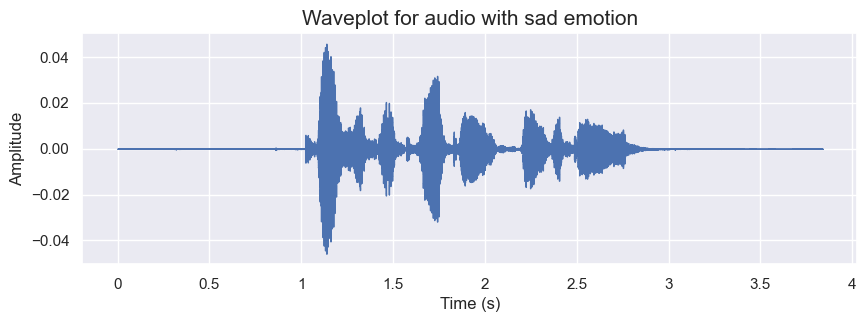

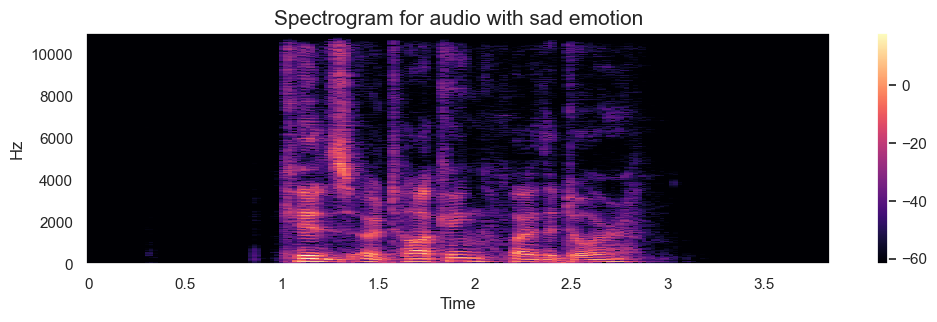

In [29]:
emotion = 'sad'
filtered_data = all_data[all_data.Emotions == emotion]
if not filtered_data.empty:
    path = filtered_data.iloc[0]['Path']
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
else:
    print(f"No audio files for emotion: {emotion}")    

In [30]:
Audio(path)

##### Happy emotion

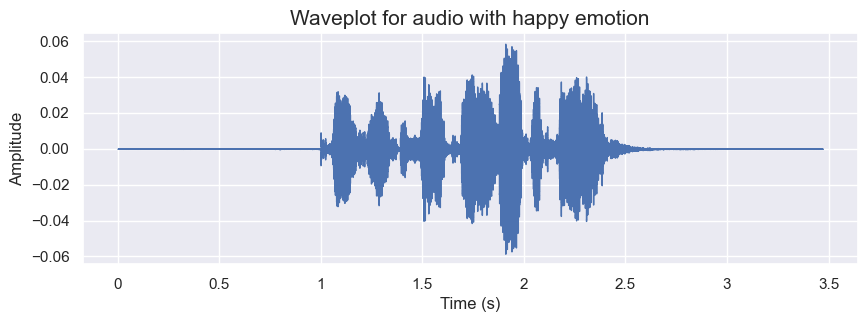

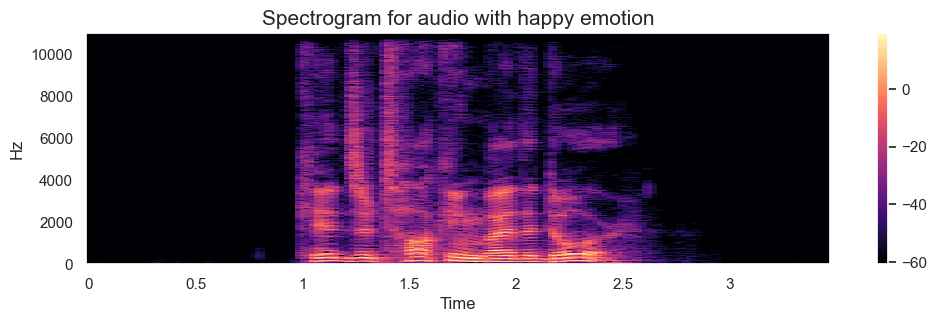

In [33]:
emotion = 'happy'
filtered_data = all_data[all_data.Emotions == emotion]
if not filtered_data.empty:
    path = filtered_data.iloc[0]['Path']
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
else:
    print(f"No audio files found for emotion: {emotion}")
        

In [35]:
Audio(path)

## Data Augmentation

* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

* The objective is to make our model invariant to those perturbations and enhance its ability to generalize.

* In order to this to work adding the perturbations must conserve the same label as the original training sample.

* In images data augmentation can be performed by shifting the image, zooming, rotating ...


First, let's check which augmentation techniques works better for our dataset.

1. **Noise Injection –** Adding random noise to the signal

2. **Time Shifting –** Moving the audio slightly forward or backward

3. **Pitch Shifting –** Changing the pitch while preserving speed

4. **Speed Variation –** Changing playback speed slightly

In [36]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [37]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [38]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [39]:
def stretch (data, rate = 0.8):
    return librosa.effects.time_stretch(data, rate=rate)

##### Checking for techniques

In [41]:
path = all_data.iloc[0]['Path']
data, sampling_rate = librosa.load(path)

##### 1. Simple Audio

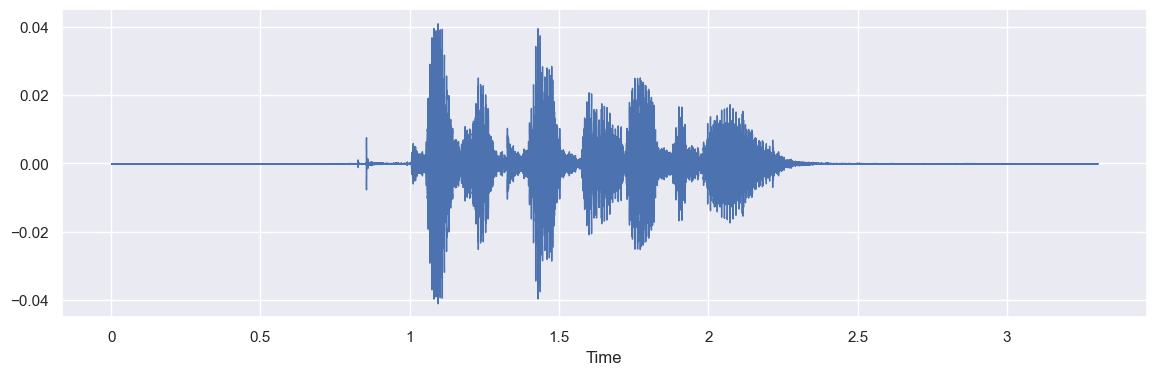

In [42]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y = data, sr=sampling_rate)
Audio(path)

##### 2. Noise Injection

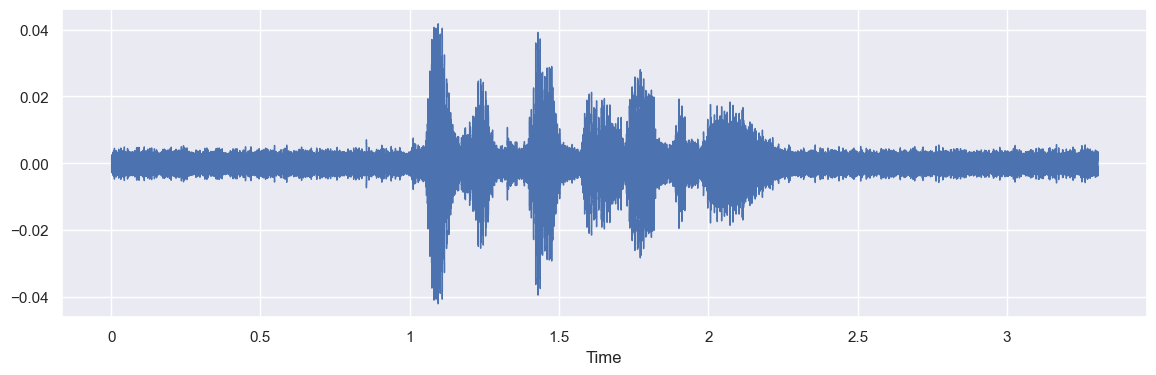

In [43]:
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

**Noise injection** is a very good augmentation technique
We can assure our training model is not overfitted

##### 3. Time shifting

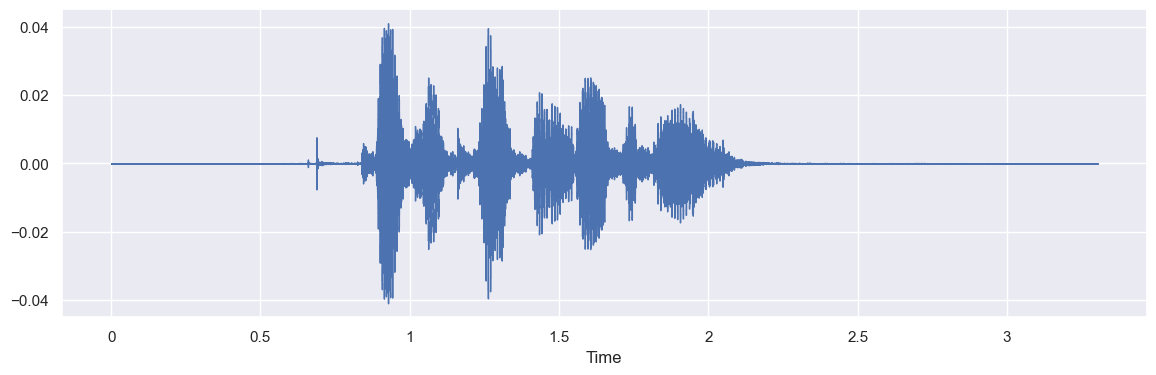

In [45]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

##### 4. Pitch shifting

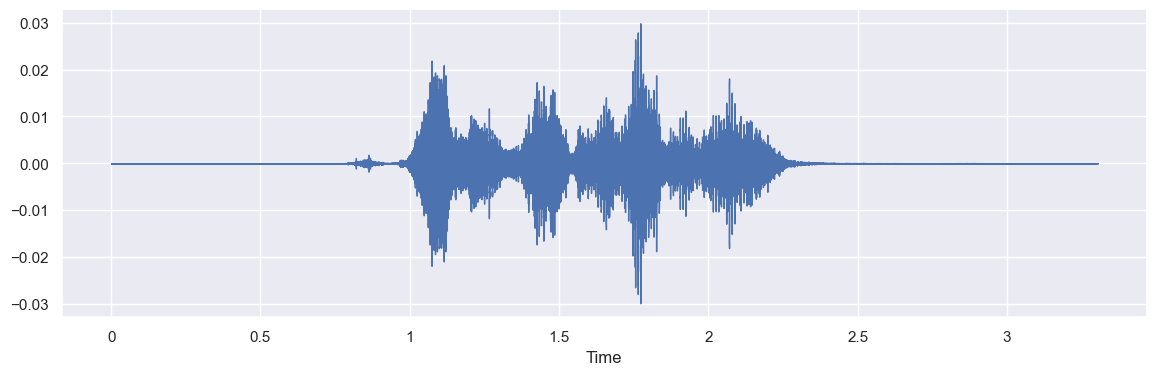

In [46]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

##### 5. Speed Variation

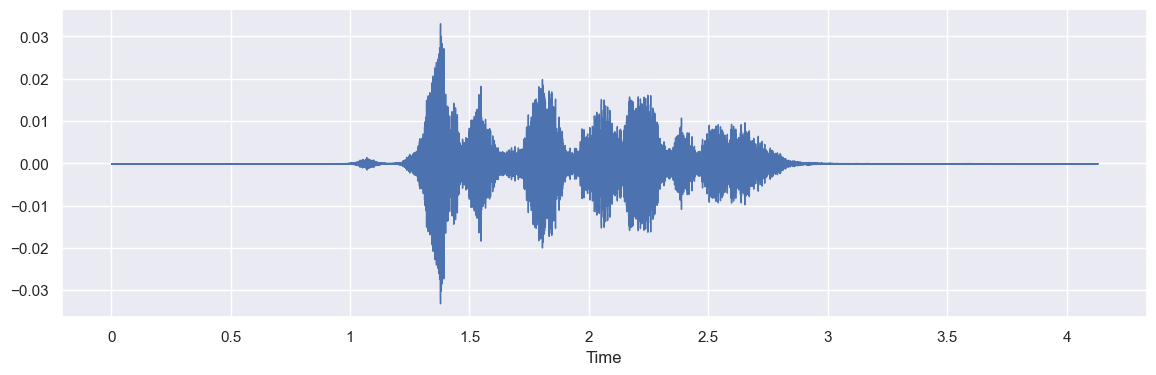

In [47]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

This document provides a **comprehensive analysis** of how well each augmentation method works for our dataset.

---

## **1. Noise Injection**
### **Method**
- Random Gaussian noise is added to the audio signal.
- Noise level is controlled using `noise_amp = 0.035*np.random.uniform()*np.amax(data)`.
- Ensures a **small perturbation** that does not alter the primary audio features.

### **Observation**
- Maintains the overall waveform while adding slight variations.  
- Helps **prevent overfitting**, making the model robust against real-world background noise.  
- Works well for all emotion categories as the emotion-related features remain intact.  

### **Effectiveness: ✅✅✅✅ (Highly Effective)**
This is one of the best augmentation techniques, as **speech emotion detection models should be resilient to background noise**.

---

## **2. Time Shifting**
### **Method**
- The signal is rolled forward or backward by a random time shift.
- Implemented using `np.roll(data, shift_range)`, where `shift_range` varies between `-5000` to `5000` samples.

### **Observation**
- Causes a temporal shift but **preserves the frequency and amplitude of the waveform**.
- The **beginning or end of the audio may be cut off**, leading to possible loss of crucial speech features.
- Works well for longer speech samples but might **distort shorter samples**.

### **Effectiveness: ✅✅✅ (Moderately Effective)**
- Can be useful but may degrade classification accuracy if key emotional cues occur at the **start or end** of the recording.

---

## **3. Pitch Shifting**
### **Method**
- Alters the pitch of the audio while keeping speed unchanged.
- Implemented using `librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)`, with `pitch_factor=0.7`.

### **Observation**
- Higher pitch shifts make voices **sound unnatural** for some emotions.
- Lower pitch shifts **retain emotional expressiveness** better.
- **Some emotions (e.g., "angry") may be misclassified** due to pitch changes affecting vocal intensity.

### **Effectiveness: ✅✅ (Partially Effective)**
- Works **well for emotions that depend on pitch** (e.g., **"happy" or "angry"**).
- However, excessive pitch shifting may distort the emotional expression, making it less effective for emotions like **"neutral" or "sad"**.

---

## **4. Speed Variation**
### **Method**
- Changes the playback speed of the audio without affecting pitch.
- Implemented using `librosa.effects.time_stretch(data, rate=0.8)`, where `rate` controls the speed change.

### **Observation**
- Slower speed enhances **melancholic** emotions like **"sad"**, making them more prominent.
- Faster speed may **exaggerate excitement or urgency**, beneficial for **"happy" or "angry"** emotions.
- **Potential issue:** Some speech samples sound unnatural when sped up too much.

### **Effectiveness: ✅✅✅ (Moderately Effective)**
- Can **enhance emotion features** but needs careful tuning.  
- Works well in combination with **other augmentation techniques**.

---

## **Final Evaluation & Recommendations**
| **Augmentation Technique** | **Effectiveness** | **Best Used For** | **Potential Issues** |
|----------------------------|------------------|------------------|------------------|
| **Noise Injection** | ✅✅✅✅ (Highly Effective) | General robustness | None |
| **Time Shifting** | ✅✅✅ (Moderately Effective) | Long speech samples | Might distort shorter samples |
| **Pitch Shifting** | ✅✅ (Partially Effective) | "Happy", "Angry" | Distorts emotions if overused |
| **Speed Variation** | ✅✅✅ (Moderately Effective) | "Sad", "Happy", "Angry" | Can sound unnatural |

### **Conclusion**
1. **Noise Injection** is the **most effective** and should be included in all training samples.  
2. **Time Shifting** is useful but should be **used carefully** to avoid truncation of crucial speech features.  
3. **Pitch Shifting** is **emotion-dependent** and should be applied selectively.  
4. **Speed Variation** enhances some emotions but may degrade others.  

To maximize **model generalization**, we recommend using **a combination of Noise Injection, Time Shifting, and Speed Variation** rather than relying on a single augmentation technique.

# Feature Engineering

### Feature Extraction
Extraction of features is a very important part in analyzing and finding relations between different things. 

Since raw audio waveforms are not directly interpretable by models, we need to convert them into numerical representations that capture essential characteristics of the signal.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![Audio Signal](AudioSignal.jpg)


In this project, we focus on extracting five key features that are commonly used in speech processing and emotion recognition:

1. Zero Crossing Rate (ZCR)

2. Chroma Short-Time Fourier Transform (Chroma_stft)

3. Mel Frequency Cepstral Coefficients (MFCCs)

4. Root Mean Square (RMS) Energy

5. Mel Spectrogram (MelSpectrogram)

Each feature provides unique insights into the audio signal, allowing the model to learn patterns related to different emotional expressions.



#### 1. Zero Crossing Rate (ZCR)

Zero Crossing Rate (ZCR) is the rate at which a signal changes its sign (crosses the zero axis) within a frame. It helps identify percussive sounds, sharp attacks, or noisy speech.

**Relevance for Emotion Recognition**

**Higher ZCR** is observed in high-energy emotions (e.g., anger, excitement).

**Lower ZCR** is common in calm or sad emotions with smooth speech patterns.

In [48]:
def extract_zcr(data, sampling_rate):
    zcr = librosa.feature.zero_crossing_rate(data)
    return np.mean(zcr)

#### 2. Chroma Short-Time Fourier Transform (Chroma_stft)

Chroma STFT represents the distribution of energy across the 12 pitch classes (A-G#) in Western music theory. 

It captures harmonic and tonal characteristics of speech.

**Relevance for Emotion Recognition**

* **Emotional speech** has distinct tonal qualities that can be captured using chroma features.

* Helps differentiate between neutral speech and expressive speech.

In [49]:
def extract_chroma_stft(data, sampling_rate):
    chroma_stft = librosa.feature.chroma_stft(y=data, sr=sampling_rate)
    return np.mean(chroma_stft)

#### 3. Mel Frequency Cepstral Coefficients (MFCCs)

MFCCs represent the short-term power spectrum of speech using the mel scale, which mimics human auditory perception. It is one of the most effective features for speech emotion recognition.

**Relevance for Emotion Recognition**

* Captures **vocal tract shape**, which varies with emotions.

* **Lower-order coefficients** represent timbre, while higher-order coefficients capture finer details.

* Useful in distinguishing between emotions like **sadness (low-energy MFCCs)** and **anger (high-energy MFCCs)**.

In [50]:
def extract_mfcc(data, sampling_rate, num_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=num_mfcc)
    return np.mean(mfccs, axis=1)

#### 4. Root Mean Square (RMS) Energy

RMS Energy measures the magnitude of an audio signal, providing insight into loudness.

**Relevance for Emotion Recognition** 

* **Higher RMS** indicates emotions like anger or excitement.
* **Lower RMS** is typical for sadness or calm speech.

In [51]:
def extract_rms(data):
    rms = librosa.feature.rms(data)
    return np.mean(rms)

#### 5. Mel Spectrogram (MelSpectrogram)

The Mel Spectrogram converts an audio signal into a spectrogram using a mel scale, which aligns with how humans perceive sound frequencies.

**Relevance for Emotion Recognition**

* Provides a **visual representation** of frequency and amplitude changes over time.

* Helps distinguish between **different speech patterns** and voice intensities.

In [52]:
def extract_melspectrogram(data, sampling_rate):
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
    return np.mean(mel_spectrogram)

In [53]:
def extract_features(data, sample_rate):
    result = np.array([])

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

##### Get Features from Original and Augmented Audio

In [54]:
def get_features(path):
    data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from original audio; without augmentation
    res1 = extract_features(data, sampling_rate)
    result = np.array(res1)
    
    # Extract features from noise-augmented audio
    noise_data = noise(data)
    res2= extract_features(noise_data, sampling_rate)
    result=  np.vstack((result, res2))
    
    # Extract features from pitched-shifted and time-stretched audio
    stretched_data = stretch(data)
    pitch_stretch_data = pitch(stretched_data, sampling_rate)
    res3 = extract_features(pitch_stretch_data, sampling_rate)
    result = np.vstack((result, res3))
    
    return result

Dataset preparation after feature extraction and augmentation.

* X, Y = [], []: Initialize empty lists to store features (X) and labels (Y).

* Loop through data_path.Path (file paths) and data_path.Emotions (labels).

* **Feature Extraction:** get_features(path) extracts features for the original and augmented versions of the audio.

**Appending Data:**
Since get_features(path) returns three feature sets per audio (original + two augmentations), we:
* * Append each feature vector (ele) to X.
* * Append the corresponding label 3 times to Y to maintain correct alignment.

In [55]:
X, Y = [], []

for path, emotion in zip(all_data.Path, all_data.Emotions):
    features = get_features(path)
    
    for feature in features:
        X.append(feature)
        Y.append(emotion)

* Convert X into a Pandas DataFrame, add a 'labels' column for emotions, and save it as features.csv.

In [56]:
Features = pd.DataFrame(X)
Features['labels'] = Y

Features.to_csv('features.csv', index=False)

Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.333370  0.794016  0.836877  0.822849  0.824210  0.822109  0.729430   
2  0.188256  0.622125  0.699215  0.753343  0.721212  0.701727  0.682356   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.290943  0.762306  0.791657  0.757998  0.748573  0.766421  0.664988   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.684446  0.717814  0.758842  ...  1.028284e-04  1.020301e-04   
2  0.662828  0.686486  0.733960  ...  8.579052e-07  9.576654e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.645752  0.708472  0.736121  ...  2.211987e-05  2.184369e-05   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  1.011603e-04  1.049905e-04  1.040645e-04  1.102968e-04  0.000103  0.000102   
2  7.733596e-07  5.233101e-07  3.592860e-07  9.261693e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640184e-06  0.000011  0.000006   
4  2.060755e-05  2.082042e-05  2.624284e-05  2.360076e-05  0.000024  0.000019   

            161   labels  
0  4.245834e-07  neutral  
1  1.009735e-04  neutral  
2  7.753986e-08  neutral  
3  4.254087e-07  neutral  
4  1.400089e-05  neutral  

[5 rows x 163 columns]

In [57]:
Features.shape

(26955, 163)

### Data Preparation
Data preparation for model training by:

* Extracting Features & Labels

* Encoding Labels for Multiclass Classification

* Splitting Data into Training & Testing Sets

* Normalizing Features for Better Model Performance

In [58]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

**Extracting Features and Labels**

In [59]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

**Splitting data into training and testing sets (75%-25% split)**

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0, shuffle=True)


**Encoding Labels: Convert categorical labels to numerical values**

In [61]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

**Normalizing Features: Scale data using StandardScaler for better model performance**

In [62]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Verifying shapes**

In [63]:
print("Training Data Shape:", x_train.shape, y_train_encoded.shape)
print("Testing Data Shape:", x_test.shape, y_test_encoded.shape)

Training Data Shape: (20216, 162) (20216,)
Testing Data Shape: (6739, 162) (6739,)


## Modelling

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

### 1. Logistic Regression Model

Logistic Regression is a simple yet effective classification algorithm that models the probability of a categorical dependent variable. 

In this implementation, we train a Logistic Regression model on extracted speech emotion features to classify emotions accurately.

##### Model Initialization

To ensure better convergence, the Logistic Regression model is initialized with a high iteration count.

In [65]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)


* Train the model on training data

In [66]:
lr_model.fit(x_train, y_train_encoded)

LogisticRegression(max_iter=1000, random_state=42)

* Make predictions on the test set

In [67]:
predictions = lr_model.predict(x_test)

* Decode predicted labels back to categorical labels

In [68]:
predictions_decoded = label_encoder.inverse_transform(predictions)

* Calculate the accuracy

In [69]:
accuracy = accuracy_score(y_test, predictions_decoded)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5498


##### Generate a classification report

In [70]:
report = classification_report(y_test, predictions_decoded, output_dict=True, zero_division=1)


* Convert the report to a Pandas DataFrame for better readability

In [72]:
report_df = pd.DataFrame(report).transpose()

report_df

precision    recall  f1-score      support
angry          0.633262  0.606742  0.619718   979.000000
disgust        0.396890  0.498458  0.441913   973.000000
fearful        0.322251  0.178723  0.229927   705.000000
happy          0.460199  0.383023  0.418079   966.000000
neutral        0.568948  0.554229  0.561492  1005.000000
sad            0.513776  0.635271  0.568100   998.000000
surprised      0.525974  0.570423  0.547297   142.000000
unknown        0.843658  0.883625  0.863179   971.000000
accuracy       0.549785  0.549785  0.549785     0.549785
macro avg      0.533120  0.538812  0.531213  6739.000000
weighted avg   0.542558  0.549785  0.541590  6739.000000

##### Confusion Matrix Visualization

Helps analyze misclassifications.

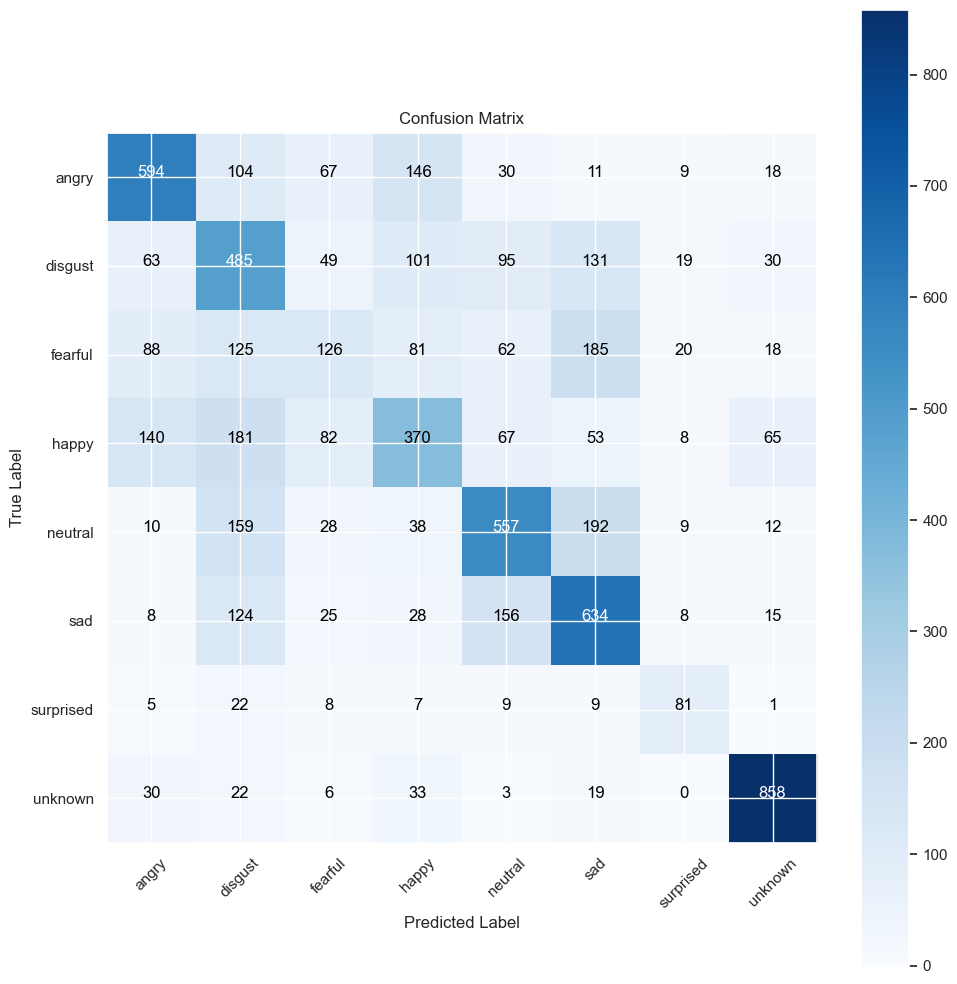

In [73]:
cm = confusion_matrix(y_test, predictions_decoded)
labels = label_encoder.classes_ 

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add text labels to each cell in the confusion matrix
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 2. XGBoost Model

In [80]:
from xgboost import XGBClassifier, plot_importance


* Initialize XGBoost classifier

In [81]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss', random_state=42)

* Train the model on training data

In [82]:
xgb.fit(x_train, y_train_encoded)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [03:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

* Make predictions on the test set

In [83]:
y_pred_xgb = xgb.predict(x_test)

* Decode predicted labels back to categorical labels


In [84]:
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

* Calculate the accuracy

In [85]:
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7630


* Generate a classification report

In [86]:
report = classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True)


* Convert the classification report into a Pandas DataFrame for better readability


In [87]:
report_df = pd.DataFrame(report).transpose()

report_df

precision    recall  f1-score      support
angry          0.796970  0.805924  0.801422   979.000000
disgust        0.667943  0.717369  0.691774   973.000000
fearful        0.675248  0.483688  0.563636   705.000000
happy          0.676877  0.709110  0.692619   966.000000
neutral        0.763916  0.792040  0.777723  1005.000000
sad            0.739791  0.780561  0.759629   998.000000
surprised      0.796610  0.661972  0.723077   142.000000
unknown        0.985626  0.988671  0.987147   971.000000
accuracy       0.763021  0.763021  0.763021     0.763021
macro avg      0.762873  0.742417  0.749628  6739.000000
weighted avg   0.762170  0.763021  0.760505  6739.000000

* Confusion Matrix Visualization

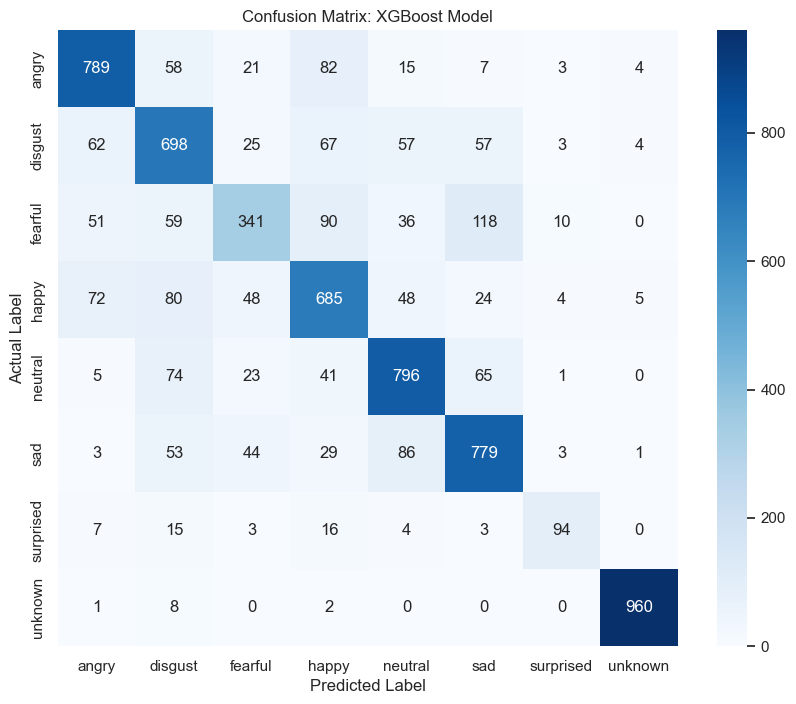

In [88]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: XGBoost Model')
plt.show()

* Plot Feature Importance

Plot feature importance based on weight (number of times a feature is used in a split)

<Figure size 1200x800 with 0 Axes>

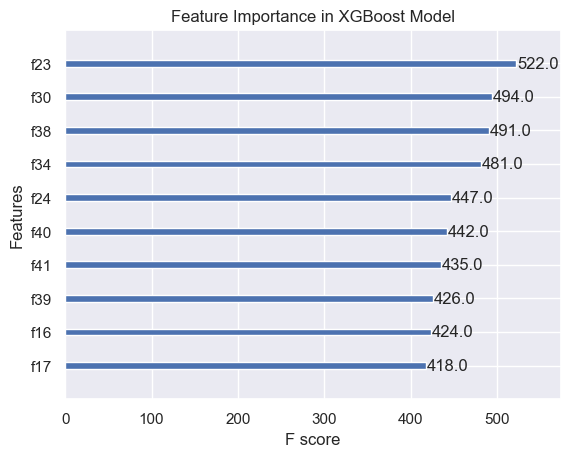

In [89]:
plt.figure(figsize=(12, 8))
plot_importance(xgb, max_num_features=10, importance_type='weight')
plt.title('Feature Importance in XGBoost Model')
plt.show()